# Workshop Notebook 3: Observability - Drift Detection

In the previous notebook you learned how to add simple validation rules to a pipeline, to monitor whether outputs (or inputs) stray out of some expected range. In this notebook, you will monitor the *distribution* of the pipeline's predictions to see if the model, or the environment that it runs it, has changed.

## Preliminaries

In the blocks below we will preload some required libraries.

In [ ]:
# run this to preload needed libraries 

import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework
from IPython.display import display
from IPython.display import Image
import pandas as pd
import json
import datetime
import time
import cv2
import matplotlib.pyplot as plt
import string
import random
import pyarrow as pa
import sys
import asyncio
pd.set_option('display.max_colwidth', None)

import sys
 
# setting path - only needed when running this from the `with-code` folder.
sys.path.append('../')

import utils

## Pre-exercise

If needed, log into Wallaroo and go to the workspace, pipeline, and most recent model version from the ones that you created in the previous notebook. Please refer to Notebook 1 to refresh yourself on how to log in and set your working environment to the appropriate workspace.

In [29]:
## blank space to log in 

wl = wallaroo.Client()

# retrieve the previous workspace, model, and pipeline version

workspace_name = 'workshop-workspace-john-cv'

workspace = wl.get_workspace(workspace_name)

# set your current workspace to the workspace that you just created
wl.set_current_workspace(workspace)

# optionally, examine your current workspace
wl.get_current_workspace()

# display the workspace, pipeline and model version
display(workspace)


{'name': 'workshop-workspace-john-cv', 'id': 13, 'archived': False, 'created_by': 'john.hansarick@wallaroo.ai', 'created_at': '2024-11-04T21:08:24.55981+00:00', 'models': [{'name': 'mobilenet', 'versions': 1, 'owner_id': '""', 'last_update_time': datetime.datetime(2024, 11, 4, 21, 9, 40, 313224, tzinfo=tzutc()), 'created_at': datetime.datetime(2024, 11, 4, 21, 9, 40, 313224, tzinfo=tzutc())}, {'name': 'cv-pixel-intensity', 'versions': 3, 'owner_id': '""', 'last_update_time': datetime.datetime(2024, 11, 5, 23, 23, 49, 703992, tzinfo=tzutc()), 'created_at': datetime.datetime(2024, 11, 5, 20, 38, 55, 258098, tzinfo=tzutc())}], 'pipelines': [{'name': 'cv-retail', 'create_time': datetime.datetime(2024, 11, 4, 21, 10, 5, 287786, tzinfo=tzutc()), 'definition': '[]'}, {'name': 'cv-retail-observe', 'create_time': datetime.datetime(2024, 11, 5, 20, 35, 25, 831787, tzinfo=tzutc()), 'definition': '[]'}, {'name': 'cv-assays-demo', 'create_time': datetime.datetime(2024, 11, 5, 21, 52, 48, 545484, tz

### Upload Computer Vision with Pixel Intensity Model

For this example, we'll be using a different Bring Your Own Predict (BYOP) of the same models used before, but this time we have an additional output field:  `avg_px_intensity`. This takes the incoming images and averages out their pixel intensity.  Typically the higher the value, the more blurred and indistinct the image is.

We'll upload it with the following.  Adjust the variable names as best fit your preferences.

```python
input_schema = pa.schema([
    pa.field('tensor', pa.list_(
        pa.list_(
            pa.list_(
                pa.float32(), # images are normalized
                list_size=640
            ),
            list_size=480
        ),
        list_size=3
    )),
])

output_schema = pa.schema([
    pa.field('boxes', pa.list_(pa.list_(pa.float32(), list_size=4))),
    pa.field('classes', pa.list_(pa.int64())),
    pa.field('confidences', pa.list_(pa.float32())),
    pa.field('avg_px_intensity', pa.list_(pa.float32())),
    pa.field('avg_confidence', pa.list_(pa.float32())),
])


model = wl.upload_model("cv-pixel-intensity", 
                        "models/model-with-pixel-intensity.zip", 
                        framework=Framework.CUSTOM,
                        input_schema=input_schema, 
                        output_schema=output_schema)
```

In [ ]:
## blank space to upload the observation model

input_schema = pa.schema([
    pa.field('tensor', pa.list_(
        pa.list_(
            pa.list_(
                pa.float32(), # images are normalized
                list_size=640
            ),
            list_size=480
        ),
        list_size=3
    )),
])

output_schema = pa.schema([
    pa.field('boxes', pa.list_(pa.list_(pa.float32(), list_size=4))),
    pa.field('classes', pa.list_(pa.int64())),
    pa.field('confidences', pa.list_(pa.float32())),
    pa.field('avg_px_intensity', pa.list_(pa.float32())),
    pa.field('avg_confidence', pa.list_(pa.float32())),
])


model = wl.upload_model("cv-pixel-intensity", 
                        "../models/model-with-pixel-intensity.zip", 
                        framework=Framework.CUSTOM,
                        input_schema=input_schema, 
                        output_schema=output_schema)

Waiting for model loading - this will take up to 10.0min.
Model is pending loading to a container runtime.
Model is attempting loading to a container runtime...successful

Ready


Create a new pipeline and add the model as our pipeline step.  We'll leave those steps out - you should know them by now.  But we'll include a recommended deployment configuration to use.

In [31]:
# run this deployment configuration

deployment_config = wallaroo.DeploymentConfigBuilder() \
    .replica_count(1) \
    .cpus(1) \
    .memory("2Gi") \
    .sidekick_cpus(model, 1) \
    .sidekick_memory(model, '6Gi') \
    .build()

In [32]:
## blank space to build the pipeline and add the model step, then deploy the pipeline

pipeline = wl.build_pipeline("cv-assays-demo")
pipeline.clear()
pipeline.add_model_step(model)

pipeline.deploy(deployment_config=deployment_config)


name,cv-assays-demo
created,2024-11-05 21:52:48.545484+00:00
last_updated,2024-11-06 16:08:59.847459+00:00
deployed,True
workspace_id,13
workspace_name,workshop-workspace-john-cv
arch,x86
accel,none
tags,
versions,"8a2f1f10-2f0c-465e-b00e-8e49122aeab1, ae57bdad-4fc1-4fae-a372-6d6ef3ba6799, 4bbfd131-1dac-4769-9922-1c8b03b90cb0, dbbeb481-087f-4bfa-8ebb-87772fb5624f, 37b3ff06-8961-4146-95c5-d78422674307, c780686b-6513-4d55-9625-b9e909ea0c22, 33141597-883b-4ecb-9f67-69aa444b3567, 7a1b6d81-07ca-4a9e-8e88-d49eed847b5e"
steps,cv-pixel-intensity


In [36]:
## blank space to check the pipeline status

pipeline.status()

{'status': 'Running',
 'details': [],
 'engines': [{'ip': '10.28.2.22',
   'name': 'engine-769df9f59b-ks9x7',
   'status': 'Running',
   'reason': None,
   'details': [],
   'pipeline_statuses': {'pipelines': [{'id': 'cv-assays-demo',
      'status': 'Running',
      'version': '8a2f1f10-2f0c-465e-b00e-8e49122aeab1'}]},
   'model_statuses': {'models': [{'name': 'cv-pixel-intensity',
      'sha': '6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0',
      'status': 'Running',
      'version': 'a2b53895-8ed9-4a84-b477-a48248638cb6'}]}}],
 'engine_lbs': [{'ip': '10.28.2.17',
   'name': 'engine-lb-6676794678-bl2l7',
   'status': 'Running',
   'reason': None,
   'details': []}],
 'sidekicks': [{'ip': '10.28.2.18',
   'name': 'engine-sidekick-cv-pixel-intensity-22-7f59bdd6db-xtdfc',
   'status': 'Running',
   'reason': None,
   'details': [],
   'statuses': '\n'},
  {'ip': '10.28.2.21',
   'name': 'engine-sidekick-cv-pixel-intensity-23-665f6f4695-mnw55',
   'status': 'Running',

### Sample Inference

For our sample inference, we'll use the file `'./data/dairy_bottles.json'` - what we're looking for is the field `out.avg_px_intensity`.  The following is one method of displaying only that field:

```python
pipeline.infer_from_file('../data/dairy_bottles.json')["out.avg_px_intensity"]
```

In [35]:
## blank space to perform sample inference

pipeline.infer_from_file('../data/dairy_bottles.json')["out.avg_px_intensity"]

0    [0.425382]
Name: out.avg_px_intensity, dtype: object

## Monitoring for Drift: Shift Happens. 

In machine learning, you use data and known answers to train a model to make predictions for new previously unseen data. You do this with the assumption that the future unseen data will be similar to the data used during training: the future will look somewhat like the past.
But the conditions that existed when a model was created, trained and tested can change over time, due to various factors.

A good model should be robust to some amount of change in the environment; however, if the environment changes too much, your models may no longer be making the correct decisions. This situation is known as concept drift; too much drift can obsolete your models, requiring periodic retraining.

Let's consider the example we've been working on: home sale price prediction. You may notice over time that there has been a change in the mix of properties in the listings portfolio: for example a dramatic increase or decrease in expensive properties (or more precisely, properties that the model thinks are expensive)

Such a change could be due to many factors: a change in interest rates; the appearance or disappearance of major sources of employment; new housing developments opening up in the area. Whatever the cause, detecting such a change quickly is crucial, so that the business can react quickly in the appropriate manner, whether that means simply retraining the model on fresher data, or a pivot in business strategy.

In Wallaroo you can monitor your housing model for signs of drift through the model monitoring and insight capability called Assays. Assays help you track changes in the environment that your model operates within, which can affect the model’s outcome. It does this by tracking the model’s predictions and/or the data coming into the model against an **established baseline**. If the distribution of monitored values in the current observation window differs too much from the baseline distribution, the assay will flag it. The figure below shows an example of a running scheduled assay.


![](https://docs.wallaroo.ai/images/current/wallaroo-tutorials/wallaroo-tutorial-features/wallaroo-model-insights-reference_files/wallaroo-model-insights-reference_35_0.png)

**Figure:** A daily assay that's been running for a month. The dots represent the difference between the distribution of values in the daily observation window, and the baseline. When that difference exceeds the specified threshold (indicated by a red dot) an alert is set.

This next set of exercises will walk you through setting up an assay to monitor the predictions of your house price model, in order to detect drift.

### NOTE

An assay is a monitoring process that typically runs over an extended, ongoing period of time. For example, one might set up an assay that every day monitors the previous 24 hours' worth of predictions and compares it to a baseline. For the purposes of these exercises, we'll be compressing processes what normally would take hours or days into minutes.


## Set Assay Baseline

In order to know whether the distribution of your model's predictions have changed, you need a baseline to compare them to. This baseline should represent how you expect the model to behave at the time it was trained. This might be approximated by the distribution of the model's predictions over some "typical" period of time. For example, we might collect the predictions of our model over the first few days after it's been deployed. For these exercises, we'll compress that to a few minutes. Currently, to set up a wallaroo assay the pipeline must have been running for some period of time, and the assumption is that this period of time is "typical", and that the distributions of the inputs and the outputs of the model during this period of time are "typical."


## Create Set Baseline

Before setting up an assay on this pipeline's output, we may want to look at the distribution of the predictions over our selected baseline period. First we'll perform a set of inferences and use that data to create our baseline values.  These are either a date period of inferences to look at, or a numpy array generated from the sample data.

### Create Set Baseline Example

Create an assay builder to monitor the output of your house price pipeline. The baseline period should be from `baseline_start` to `baseline_end`. 

* You will need to know the name of your output variable, and the name of the model in the pipeline.  In our case, we will be relying on the post processing Python model we deployed with the pipeline.

Here's an example.

```python
import datetime
import time

assay_baseline_start = datetime.datetime.now()

baseline_start = datetime.datetime.now(datetime.timezone.utc)

## Blank space to create an assay builder and examine the baseline distribution

blurred_images = [
    '../data/blurred_dairy_bottles.json',
    "../data/blurred_dairy_products.json",
    "../data/blurred_product_cheeses.json",
]


baseline_images = [
    "../data/dairy_bottles.json",
    "../data/dairy_products.json",
    "../data/product_cheeses.json",
]

for image in baseline_images:
    with open(image, 'r') as file:
        df = pd.read_json(image)
    pipeline.infer(df)

time.sleep(60)
assay_baseline_end = datetime.datetime.now()
```


In [ ]:
## blank space to set the baseline data

import datetime
import time

assay_baseline_start = datetime.datetime.now()

baseline_start = datetime.datetime.now(datetime.timezone.utc)

## Blank space to create an assay builder and examine the baseline distribution

blurred_images = [
    '../data/blurred_dairy_bottles.json',
    "../data/blurred_dairy_products.json",
    "../data/blurred_product_cheeses.json",
]


baseline_images = [
    "../data/dairy_bottles.json",
    "../data/dairy_products.json",
    "../data/product_cheeses.json",
]

for image in baseline_images:
    with open(image, 'r') as file:
        df = pd.read_json(image)
    pipeline.infer(df)

time.sleep(60)
assay_baseline_end = datetime.datetime.now()

## Create Assay

Baselines are created with the `wallaroo.client.build_assay` method and take the following arguments.

| Parameter | Type | Description |
|---|---|---|
| **assay_name** | (*String*) (*Required*) | The name of the assay.  Assay names **must** be unique across the Wallaroo instance. |
| **pipeline** | (*wallaroo.pipeline*) (*Required*) | The pipeline the assay retrieves data from. |
| **model_name** | (*String*) (*Required*) | The name of the model.  This must be one of the models deployed in the pipeline. |
| **iopath** | (*String*) (*Required*) | The input/output path of "output|input {field_name} {field_index}".  For example, `"output avg_conf 0"` to use the model's outputs field `avg_conf` at index `0` |
| **baseline_start** | (*datetime.datetime*) (*Optional*) | The start time for the inferences to use as the baseline.  If `baseline_start` is used, it **must** be paired with `baseline_end` and **not** `baseline_data`.
| **baseline_end** | (*datetime.datetime*) (*Optional*) | The end time of the baseline window. the baseline. Windows start immediately after the baseline window and are run at regular intervals continously until the assay is deactivated or deleted.  If `baseline_end` is used, it **must** be paired with `baseline_start` and **not** `baseline_data`.
| **baseline_data** | (*numpy.array*) (*Optional*) | The baseline data in numpy array format.  If `baseline_data` is used, `baseline_start` and `baseline_end` must **not** be used. |

Baseline data **must** be either `baseline_start` **and** `baseline_end`, or **baseline_data**.

### Create Assay Exercise

For this exercise, we will create the assay, then display the baseline histogram from the assay.

Sample code:

```python
assay_baseline_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                               pipeline=pipeline, 
                               iopath="output avg_px_intensity 0",
                               baseline_start=assay_baseline_start,
                               baseline_end=assay_baseline_end)


# create the baseline from the dates
assay_config_from_dates = assay_baseline_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_baseline_from_dates.baseline_histogram()
```

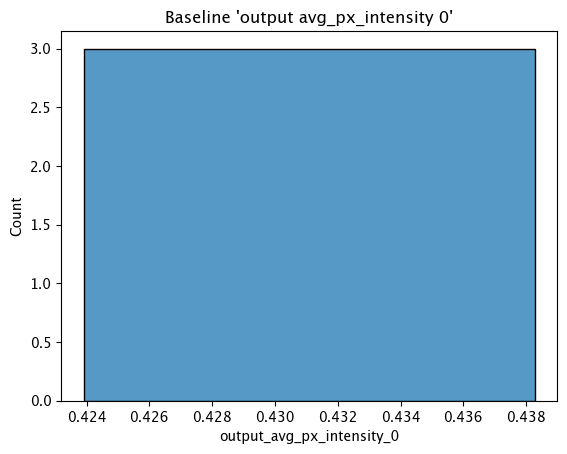

In [ ]:
## blank space to create the assay baseline

assay_baseline_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                               pipeline=pipeline, 
                               iopath="output avg_px_intensity 0",
                               baseline_start=assay_baseline_start,
                               baseline_end=assay_baseline_end)


# create the baseline from the dates
assay_config_from_dates = assay_baseline_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_baseline_from_dates.baseline_histogram()

## Assay Windows

An assay should detect if the distribution of model predictions changes from the above distribution over regularly sampled observation windows. This is called *drift*.

To show drift, we'll run more data through the pipeline -- first some data drawn from the same distribution as the baseline (`lowprice_data`). Then, we will gradually introduce more data from a different distribution (`highprice_data`). We should see the difference between the baseline distribution and the distribution in the observation window increase.

To set up the data, you should do something like the below. It will take a while to run, because of all the `sleep` intervals.

You will need the `assay_window_end` for a later exercise.

**IMPORTANT NOTE**:  To generate the data for the assay, this process may take 4-5 minutes.  Because the shortest period of time for an assay window is 1 minute, the intervals of inference data are spaced to fall within that time period.

```python

## Blank space to create an assay builder and examine the baseline distribution

# run a set of blurred images

import datetime
import time

assay_window_start = datetime.datetime.now(datetime.timezone.utc)
time.sleep(60)

for image in blurred_images:
    with open(image, 'r') as file:
        df = pd.read_json(image)
    pipeline.infer(df)

time.sleep(60)

# run a set of normal images

for image in baseline_images:
    with open(image, 'r') as file:
        df = pd.read_json(image)
    pipeline.infer(df)

time.sleep(60)
assay_window_end = datetime.datetime.now(datetime.timezone.utc)
```


In [ ]:
## blank space to  create an assay builder and examine the baseline distribution

# run a set of blurred images

import datetime
import time

assay_window_start = datetime.datetime.now(datetime.timezone.utc)
time.sleep(60)

for image in blurred_images:
    with open(image, 'r') as file:
        df = pd.read_json(image)
    pipeline.infer(df)

time.sleep(60)

# run a set of normal images

for image in baseline_images:
    with open(image, 'r') as file:
        df = pd.read_json(image)
    pipeline.infer(df)

time.sleep(60)
assay_window_end = datetime.datetime.now(datetime.timezone.utc)

## Define Assay Parameters

Now we're finally ready to set up an assay!

### The Observation Window

Once a baseline period has been established, you must define the window of observations that will be compared to the baseline. For instance, you might want to set up an assay that runs *every 12 hours*, collects the *previous 24 hours' predictions* and compares the distribution of predictions within that 24 hour window to the baseline. To set such a comparison up would look like this:

```python
assay_builder.window_builder().add_width(hours=24).add_interval(hours=12)
```

In other words **_width_** is the width of the observation window, and **_interval_** is how often an assay (comparison) is run. The default value of *width* is 24 hours; the default value of *interval* is to set it equal to *width*. The units can be specified in one of: `minutes`, `hours`, `days`, `weeks`.

### The Comparison Threshold
Given an observation window and a baseline distribution, an assay computes the distribution of predictions in the observation window. It then calculates the "difference" (or "distance") between the observed distribution and the baseline distribution. For the assay's default distance metric (which we will use here), a good starting threshold is 0.1. Since a different value may work best for a specific situation, you can try interactive assay runs on historical data to find a good threshold, as we do in these exercises.

To set the assay threshold for the assays to 0.1:

```python
assay_builder.add_alert_threshold(0.1)
```

### Running an Assay on Historical Data

In this exercise, you will build an **interactive assay** over historical data. To do this, you need an end time (`endtime`). 

Depending on the historical history, the window and interval may need adjusting.  If using the previously generated information, an interval window as short as 1 minute may be useful.

Assuming you have an assay builder with the appropriate window parameters and threshold set, you can do an interactive run and look at the results would look like this.

By default, assay start date is set to 24 hours from when the assay was created.  For this example, we will set the `assay.window_builder.add_start` to set the assay window to start at the beginning of our data, and `assay.add_run_until` to set the time period to stop gathering data from.

```python
# set the end of the interactive run
assay_builder.add_run_until(endtime)

# set the window

assay_builder.window_builder().add_width(hours=24).add_interval(hours=12).add_start(start_time)

assay_results = assay_builder.build().interactive_run()
df = assay_results.to_dataframe() # to return the results as a table
assay_results.chart_scores() # to plot the run
```

### Define Assay Parameters Exercise

Use the assay_builder you created in the previous exercise to set up an interactive assay. 
* The assay should run every minute, on a window that is a minute wide. 
* Set the alert threshold to 0.1.  
* You can use `assay_window_end` (or a later timestamp) as the end of the interactive run.

Examine the assay results. Do you see any drift?

To try other ways of examining the assay results, see the ["Interactive Assay Runs" section of the Model Insights tutorial](https://docs.wallaroo.ai/wallaroo-tutorials/wallaroo-tutorial-features/wallaroo-model-insights/#interactive-assay-runs).

Here's some code to use.

```python
assay_baseline_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                               pipeline=pipeline, 
                               iopath="output avg_px_intensity 0",
                               baseline_start=assay_baseline_start,
                               baseline_end=assay_baseline_end)


# # The end date to gather inference results
assay_baseline_from_dates.add_run_until(datetime.datetime.now(datetime.timezone.utc))

# # Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)


# create the baseline from the dates
assay_config_from_dates = assay_baseline_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()


df = assay_results_from_dates.to_dataframe()
display(assay_results_from_dates.chart_scores())
display(df)

```


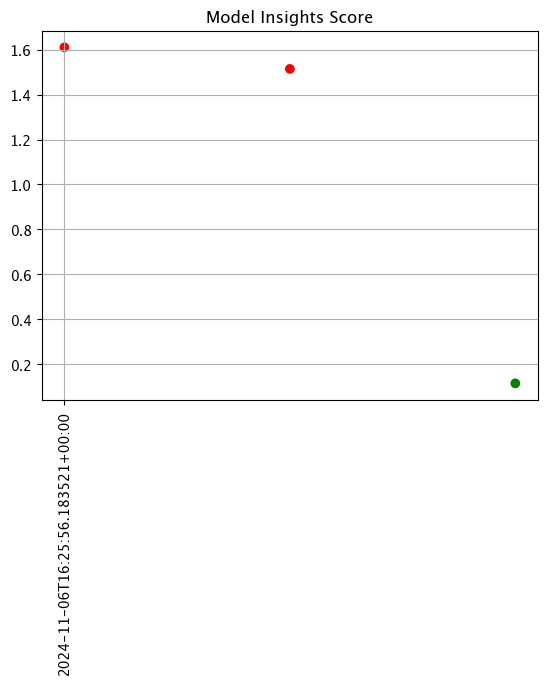

None

,id,assay_id,assay_name,iopath,pipeline_id,pipeline_name,workspace_id,workspace_name,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,None,None,assays from date baseline,,None,,None,None,1.609952,2024-11-06T16:25:56.183521+00:00,0.423923,0.438358,0.429229,0.425407,0.006484,None,0.25,Alert
1,None,None,assays from date baseline,,None,,None,None,1.514058,2024-11-06T16:26:56.183521+00:00,0.425382,0.425382,0.425382,0.425382,0.000000,None,0.25,Alert
2,None,None,assays from date baseline,,None,,None,None,0.115525,2024-11-06T16:27:56.183521+00:00,0.423913,0.438276,0.431094,0.431094,0.007181,None,0.25,Ok


In [64]:
## blank space to run the assay with adjusted 

assay_baseline_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                               pipeline=pipeline, 
                               iopath="output avg_px_intensity 0",
                               baseline_start=assay_baseline_start,
                               baseline_end=assay_baseline_end)


# # The end date to gather inference results
assay_baseline_from_dates.add_run_until(datetime.datetime.now(datetime.timezone.utc))

# # Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)


# create the baseline from the dates
assay_config_from_dates = assay_baseline_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()


df = assay_results_from_dates.to_dataframe()
display(assay_results_from_dates.chart_scores())
display(df)

## Schedule an Assay for Ongoing Data

(We won't be doing an exercise here, this is for future reference).

Once you are satisfied with the parameters you have set, you can schedule an assay to run regularly .

```python
assay_baseline_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                               pipeline=pipeline, 
                               iopath="output avg_px_intensity 0",
                               baseline_start=assay_baseline_start,
                               baseline_end=assay_baseline_end)


# # The end date to gather inference results
assay_baseline_from_dates.add_run_until(datetime.datetime.now(datetime.timezone.utc))

# # Set the interval and window to one minute each, set the start date for gathering inference results
assay_baseline_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# now schedule the assay
assay_id = assay_baseline_from_dates.upload()
```

You can use the assay id later to get the assay results.

In [ ]:
# assay_id = assay_builder.upload()

## Cleaning up.

Now that the workshop is complete, don't forget to undeploy your pipeline to free up the resources.


In [ ]:
## blank space to undeploy your pipeline

pipeline.undeploy()


You have now walked through setting up a basic assay and running it over historical data.

## Congratulations!

In this workshop you have
* Deployed a single step house price prediction pipeline and sent data to it.
* Compared two house price prediction models in an A/B test
* Compared two house price prediction models in a shadow deployment.
* Swapped the "winner" of the comparisons into the house price prediction pipeline.
* Set validation rules on the pipeline.
* Set up an assay on the pipeline to monitor for drift in its predictions.

Great job!